In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import json
%reload_ext autoreload
%autoreload 2

In [2]:
from survey_ops.coreRL.data_processing import *
from survey_ops.coreRL.offline_dataset import OfflineDECamDataset

In [3]:
from survey_ops.utils import ephemerides

In [4]:
with open('../configs/global_config.json', 'r') as f:
      gcfg = json.load(f)
with open('../experiment_results/az_grid_config.json', 'r') as f:
      cfg = json.load(f)
with open(gcfg['paths']['LOOKUP_DIR'] + '/' + gcfg['files']['FIELD2NAME'], 'r') as f:
    field2name = json.load(f)

In [5]:
df = load_raw_data_to_dataframe(fits_path=None,
                                json_path=gcfg['paths']['FITS_DIR'] + '/' + gcfg['files']['DECJSON'])

In [6]:
cfg['data']['specific_years'] = [2018]
cfg['data']['specific_months'] = [12]
cfg['data']['specific_days'] = np.arange(0, 10)


In [7]:
cfg['data']['include_bin_features'] = True

In [8]:
cfg['data']['additional_bin_features'] = ['ha', 'moon_distance']

In [9]:
cfg['data']['additional_bin_features']

['ha', 'moon_distance']

In [10]:
cfg['model']['grid_network'] = 'single_bin_scorer'

In [11]:
cfg['model']['grid_network']

'single_bin_scorer'

In [12]:


cfg['data']['bin_space']

'azel'

In [13]:
d = OfflineDECamDataset(df=df, cfg=cfg, gcfg=gcfg)

Calculating zenith states: 100%|██████████| 9/9 [00:00<00:00, 1066.53it/s]
Calculating bin features for all healpix bins and timestamps: 100%|██████████| 1269/1269 [00:06<00:00, 206.02it/s]
Normalizing bin features: 100%|██████████| 3008/3008 [00:00<00:00, 79398.28it/s]


In [14]:
import matplotlib.pyplot as plt

(array([381250., 173750., 132500., 125000., 127332., 127668., 125000.,
        132500., 173750., 381250.]),
 array([-0.99999195, -0.79999357, -0.59999514, -0.39999676, -0.19999838,
         0.        ,  0.19999844,  0.39999682,  0.5999952 ,  0.79999357,
         0.99999195]),
 <BarContainer object of 10 artists>)

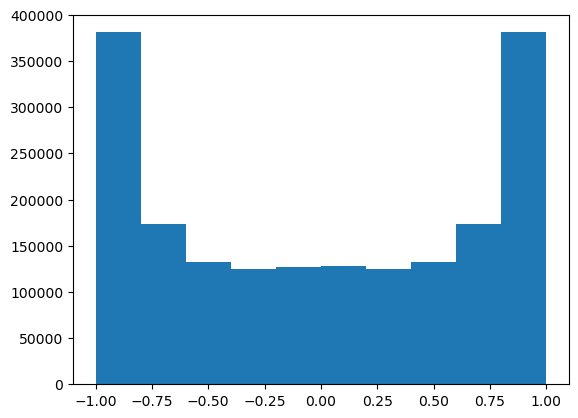

In [31]:
plt.hist(d.bin_states[:, :, 1].flatten().detach().numpy())

In [32]:
d.base_bin_feature_names

['ha', 'moon_distance']

In [33]:
trainloader, valoader = d.get_dataloader(16, 4, False, 1)

In [34]:
train_iter = iter(trainloader)

In [35]:
batch = next(train_iter)

In [36]:
state, expert_actions, rewards, next_state, dones, action_masks, bin_states, next_bin_states = batch

In [37]:
bin_states.shape

torch.Size([16, 1504, 3])

In [38]:
from survey_ops.coreRL.neural_nets import ScoreMLP, MLP

In [23]:
state.shape

torch.Size([16, 22])

In [24]:
mlp = MLP(observation_dim=state.shape[-1], action_dim=1504)
score_mlp = ScoreMLP(input_dim=bin_states.shape[-1] + state.shape[-1], hidden_dim=512)

In [25]:
score_mlp.forward(x_glob=state, x_bin=bin_states).shape

torch.Size([16, 1504])

In [26]:
bin_states.dim()

3

In [31]:
state.dim()

2

In [28]:
import torch

if torch.cuda.is_available():
    # Set the device you want to check (e.g., device 0)
    device = torch.device("cuda:0")
    
    # Get total memory, allocated memory, and reserved memory
    total_memory = torch.cuda.get_device_properties(device).total_memory # Total physical GPU memory
    allocated_memory = torch.cuda.memory_allocated(device)             # Current memory used by tensors
    reserved_memory = torch.cuda.memory_reserved(device)               # Memory reserved by PyTorch's caching allocator

    # Convert bytes to GB for readability
    def bytes_to_gb(bytes_val):
        return round(bytes_val / (1024**3), 2)

    print(f"\nGPU Memory (Device 0):")
    print(f"Total Memory: {bytes_to_gb(total_memory)} GB")
    print(f"Allocated Memory (Used by Tensors): {bytes_to_gb(allocated_memory)} GB")
    print(f"Reserved Memory (Cached by PyTorch): {bytes_to_gb(reserved_memory)} GB")
    
    # Free memory within the reserved pool (free = reserved - allocated)
    free_reserved_memory = reserved_memory - allocated_memory
    print(f"Free in Reserved Pool: {bytes_to_gb(free_reserved_memory)} GB")




GPU Memory (Device 0):
Total Memory: 15.46 GB
Allocated Memory (Used by Tensors): 0.0 GB
Reserved Memory (Cached by PyTorch): 0.0 GB
Free in Reserved Pool: 0.0 GB
